# TPE

In [20]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from scipy.stats import norm,truncnorm,uniform
from scipy import integrate

# 共通
LB = float(0)
UB = float(100)
NOISE = 0.001
N_STARTUP_TRIALS = 1
N_TRIALS = 50

N_EI_CANDIDATES = 24
EPS = 1e-12
SEED=1


def f(X, noise=NOISE):
    y = 0.4*norm.pdf(X, 10, 10)+0.2*norm.pdf(X, 50, 10)+0.4*norm.pdf(X, 90, 10)
    return y/0.016

In [21]:
def plot_points(X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    plt.plot(X, Y, 'k-', lw=1, label='Objective function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_approximation(X, Y, X_sample, Y_sample,indices_below,indices_above, X_next=None, show_legend=False):
    plt.plot(X, Y, 'k-', lw=1, label='Objective function')
    plt.plot(X_sample[indices_below], Y_sample[indices_below], 'bx', mew=3, label='Noisy samples(Lower)')
    plt.plot(X_sample[indices_above], Y_sample[indices_above], 'rx', mew=3, label='Noisy samples(Greater)')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_density(X, below, above ,samples_below, X_next, show_legend=False):
    plt.plot(X, below, 'b--', lw=1, label='Lower function')
    plt.plot(X, above, 'r-.', lw=1, label='Greater function')
    plt.vlines(samples_below,ymin=0, ymax=1, ls='--', lw=1)
    plt.axvline(x=X_next, ls='--', c='r', lw=1)
    if show_legend:
        plt.legend()
        
def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'k-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()    
        


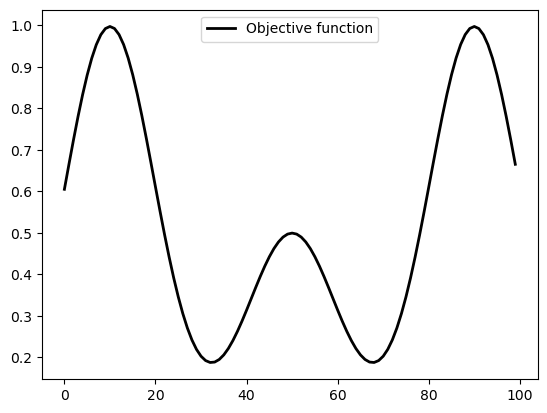

In [22]:
# Dense grid of points within bounds
X = np.arange(LB, UB, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'k-', lw=2, label='Objective function')
# plt.plot(X, f(X), 'bx', lw=1, alpha=0.3, label='Samples')
# plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend()

plt.show()

In [23]:
def default_gamma(x):
    return min(int(np.ceil(0.1 * x)), 25)

In [24]:
def default_weights(x, n_samples_lower=25):
    if x == 0:
        return np.asarray([])
    elif x < n_samples_lower:
        return np.ones(x)
    else:
        ramp = np.linspace(1.0 / x, 1.0, num=x - n_samples_lower)
        flat = np.ones(n_samples_lower)
        return np.concatenate([ramp, flat], axis=0)

In [25]:
#サンプル点のweightをつける
#weightsは後にmuやsigmaの選択に利用される
#muやsigmaは観測されたデータの旧->新順に対応しており、weightは後半の方がおおきな重み(1.0)になるようにしているので、新しいものが選ばれやすくなっている
#lowerが25個未満までは全て1となる
def calculate_weights(n_observations,predetermined_weights=None) -> np.ndarray:
    
    # We decide the weights.
    consider_prior = True
    prior_weight = 1.0
    weights_func = default_weights
    n_observations = n_observations

    if n_observations == 0:
        consider_prior = True

    if predetermined_weights is None:
        w = weights_func(n_observations)[:n_observations]
    else:
        w = predetermined_weights[:n_observations]

    if consider_prior:
        # TODO(HideakiImamura) Raise `ValueError` if the weight function returns an ndarray of
        # unexpected size.
        weights = np.zeros(n_observations + 1)
        weights[:-1] = w
        weights[-1] = prior_weight
    else:
        weights = w
    weights /= weights.sum()
    return weights

In [26]:
#サンプル点の平均分散
#muはvalueからきており、パラメータの値となる
#sigmaはパラメータの値を順に並べたときに両隣との差分をとって大きかったほうの値
def calculate_numerical_params(observations):

        n_observations = len(observations)
        consider_prior = True
        consider_endpoints = False
        consider_magic_clip = True
        multivariate = False #多変量
        sigmas0 = None #multivariateがTrueの時に必要
        low = LB
        high = UB
        assert low is not None
        assert high is not None
        assert len(observations) == n_observations

        if n_observations == 0:
            consider_prior = True

        prior_mu = 0.5 * (low + high)
        prior_sigma = 1.0 * (high - low)

        if consider_prior:
            mus = np.empty(n_observations + 1)
            mus[:n_observations] = observations
            mus[n_observations] = prior_mu
            sigmas = np.empty(n_observations + 1)
        else:
            mus = observations
            sigmas = np.empty(n_observations)

        if multivariate:
            assert sigmas0 is not None
            sigmas[:] = sigmas0 * (high - low)
        else:
            assert sigmas0 is None
            sorted_indices = np.argsort(mus)
            sorted_mus = mus[sorted_indices]
            sorted_mus_with_endpoints = np.empty(len(mus) + 2, dtype=float)
            sorted_mus_with_endpoints[0] = low
            sorted_mus_with_endpoints[1:-1] = sorted_mus
            sorted_mus_with_endpoints[-1] = high

            #隣接するパラメータの値の差を比較し、大きいほうを選択
            sorted_sigmas = np.maximum(
                sorted_mus_with_endpoints[1:-1] - sorted_mus_with_endpoints[0:-2],
                sorted_mus_with_endpoints[2:] - sorted_mus_with_endpoints[1:-1],
            )

            #両端の値はそれより中の値で埋める
            if not consider_endpoints and sorted_mus_with_endpoints.shape[0] >= 4:
                sorted_sigmas[0] = sorted_mus_with_endpoints[2] - sorted_mus_with_endpoints[1]
                sorted_sigmas[-1] = sorted_mus_with_endpoints[-2] - sorted_mus_with_endpoints[-3]

            arg = np.argsort(sorted_indices)
            #argsortをさらにargsortしたものをsortしたものに使うと、元の順番にもどる
            sigmas[:] = sorted_sigmas[arg]
            
        # We adjust the range of the 'sigmas' according to the 'consider_magic_clip' flag.
        maxsigma = 1.0 * (high - low)
        if consider_magic_clip:
            minsigma = 1.0 * (high - low) / min(100.0, (1.0 + len(mus)))
        else:
            minsigma = EPS
        sigmas = np.asarray(np.clip(sigmas, minsigma, maxsigma))
        if consider_prior:
            sigmas[n_observations] = prior_sigma

        return mus, sigmas

In [27]:
def split_observation_pairs(loss_values,n_below):
    #lossの昇順に並べてそのインデックスを取得
    index_loss_ascending = np.argsort(loss_values)
    #インデックスを2つに分けてそれを昇順にならべることで、後のほうに新しいものが来るようになる
    indices_below = np.sort(index_loss_ascending[:n_below])
    indices_above = np.sort(index_loss_ascending[n_below:])
    return indices_below, indices_above

In [28]:
def build_observation(values,indices):
    param_values = values[indices]
    observation = param_values[~np.isnan(param_values)]
    return observation

In [29]:
#muとsigmaから正規分布を作り、サンプルする
#主に最近得られた24個のものを重点的に取得する
#24はweightの作成時に使用している(<25のこと)
def sample(mus,sigmas,weights,rng,i,size=N_EI_CANDIDATES):
    samples_dict = {}
        
    #size個得られることに注意
    #weightsは観測した数だが、それに寄らない値になる
    active = rng.choice(len(weights), size, p=weights)
        
    # We restore parameters of parzen estimators.
    low = LB
    high = UB
    mus = mus
    sigmas = sigmas
    assert low is not None
    assert high is not None
    assert mus is not None
    assert sigmas is not None
    
    # We sample from truncnorm.
    trunc_low = (low - mus[active]) / sigmas[active]
    trunc_high = (high - mus[active]) / sigmas[active]
    samples = np.full((), fill_value=high + 1.0, dtype=np.float64)

    while (samples >= high).any():
        samples = np.where(
            samples < high,
            samples,
            #一度でsize個得られる
            truncnorm.rvs(
                trunc_low,
                trunc_high,
#                 size=size,
                loc=mus[active],
                scale=sigmas[active],
                random_state=rng,
            ),
            )
        
    return samples

In [30]:
def normal_cdf(x: float, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:

    mu, sigma = map(np.asarray, (mu, sigma))
    denominator = x - mu
    numerator = np.maximum(np.sqrt(2) * sigma, EPS)
    z = denominator / numerator
    return 0.5 * (1 + scipy.special.erf(z))

In [31]:
def logsum_rows(x: np.ndarray) -> np.ndarray:

    x = np.asarray(x)
    m = x.max(axis=1)
    return np.log(np.exp(x - m[:, None]).sum(axis=1)) + m

In [32]:
def gmm_log_pdf(samples,weights,mus,sigmas):
        
        n_observations = len(weights)
        n_samples = samples.size
        if n_samples == 0:
            return np.asarray([], dtype=float)
        
        component_log_pdf = np.zeros((n_samples, n_observations))

        # We restore parameters of parzen estimators.
        low = LB
        high = UB
        q = None
        mus = mus
        sigmas = sigmas
        assert low is not None
        assert high is not None
        assert mus is not None
        assert sigmas is not None

        cdf_func = normal_cdf
        p_accept = cdf_func(high, mus, sigmas) - cdf_func(low, mus, sigmas)

        #サンプリングしたもの(パラメータの値)をmusで引く。ただし次元数は一致していないので、sampleの次元*musの次元となる。
        distance = samples[:, None] - mus
        mahalanobis = distance / np.maximum(sigmas, EPS)
        z = np.sqrt(2 * np.pi) * sigmas
        coefficient = 1 / z / p_accept
        #muとsigmaで正規分布を作成し、サンプル点の尤度を得る
        log_pdf = -0.5 * mahalanobis ** 2 + np.log(coefficient)
                    
        component_log_pdf += log_pdf
    
        #尤度を足してsampleの次元に戻す
        #最後のほうに重みがつく
        ret = scipy.special.logsumexp(component_log_pdf + np.log(weights), axis=1)
        
        return ret


In [33]:
#サンプル点の尤度で比較を行い、大きいところを次の選択とする
def compare(samples,log_l,log_g):
    n_samples = samples.size
    if n_samples:
        score = log_l - log_g
        if n_samples != score.size:
            raise ValueError(
                "The size of the 'samples' and that of the 'score' "
                "should be same. "
                "But (samples.size, score.size) = ({}, {})".format(n_samples, score.size)
            )
        next_value_index = np.argmax(score)
        return samples[next_value_index]
    else:
        raise ValueError(
            "The size of 'samples' should be more than 0."
            "But samples.size = {}".format(n_samples)
        )

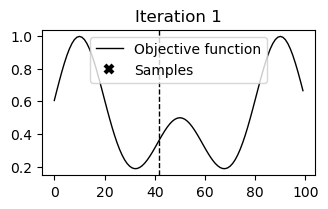

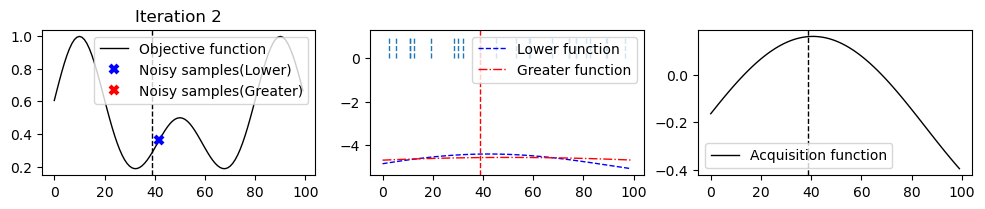

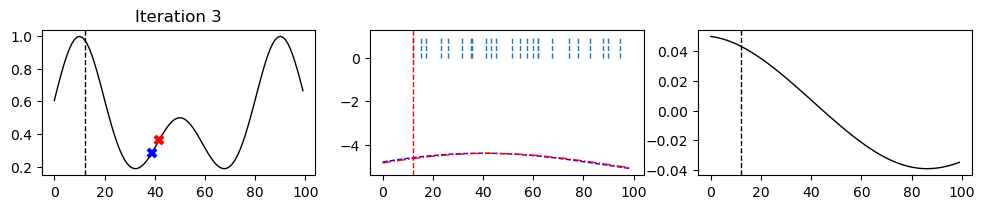

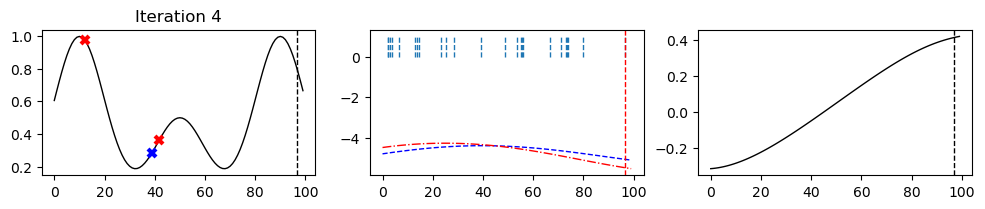

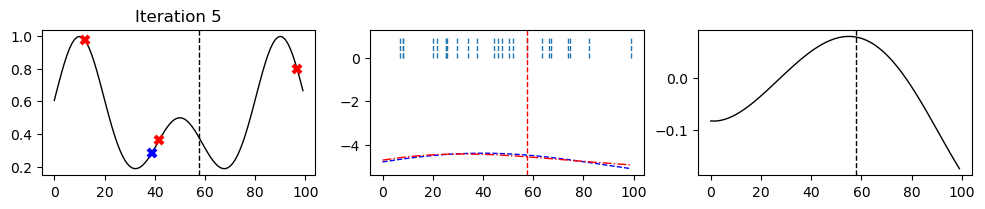

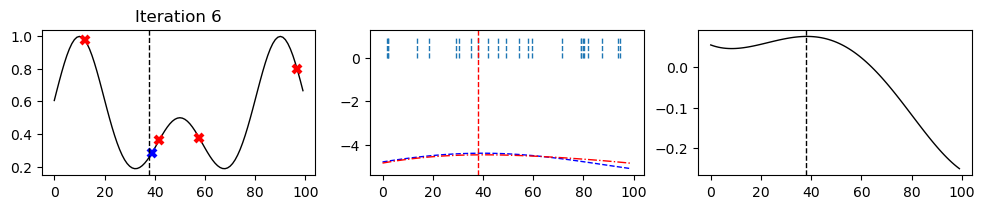

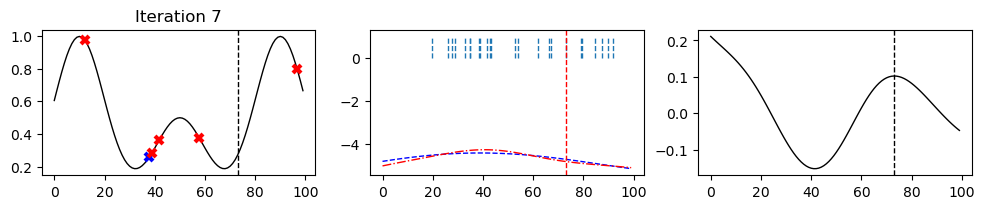

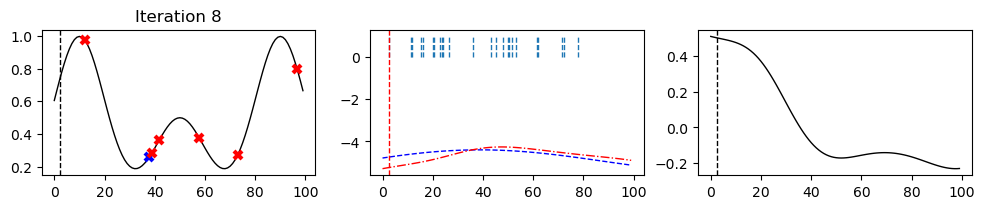

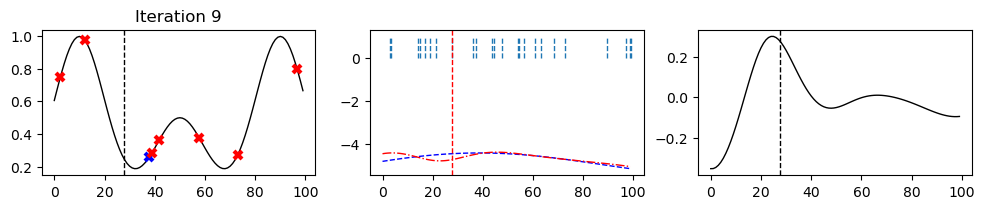

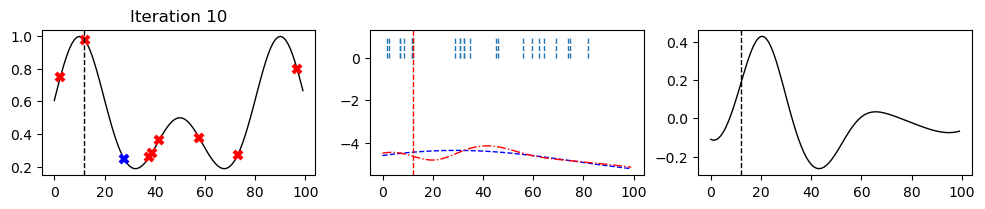

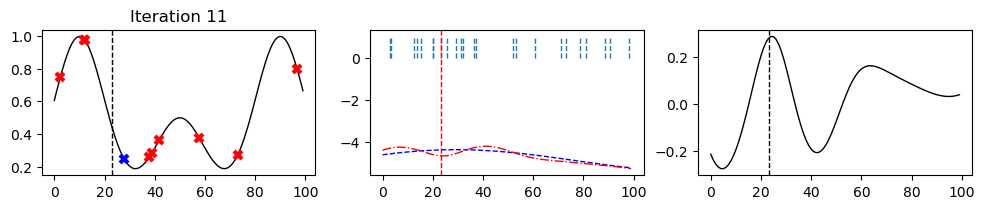

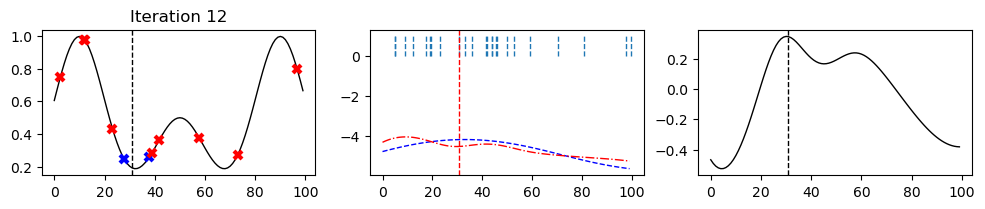

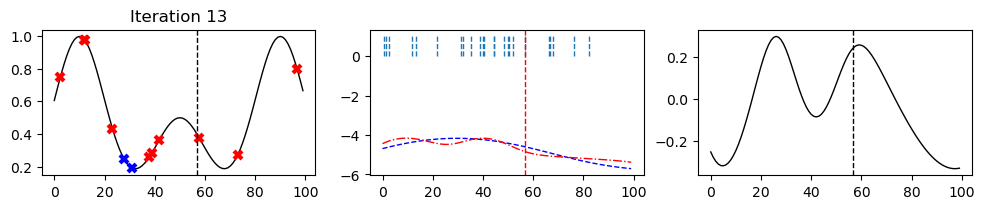

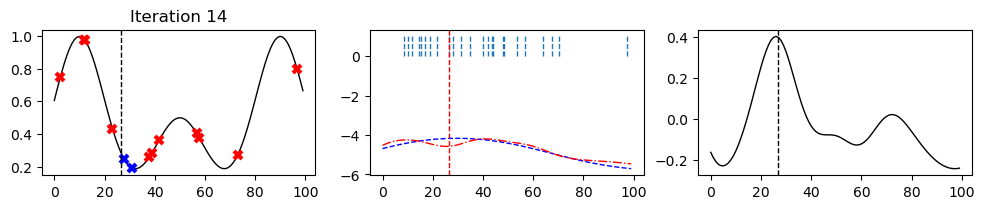

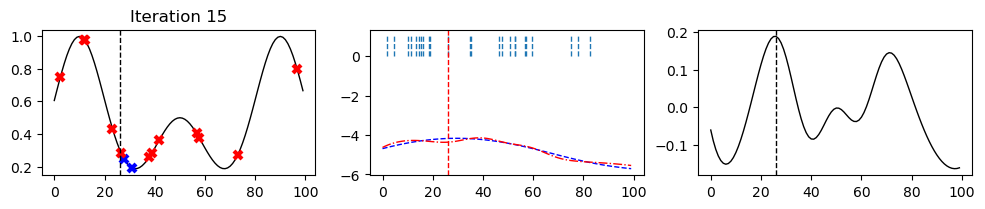

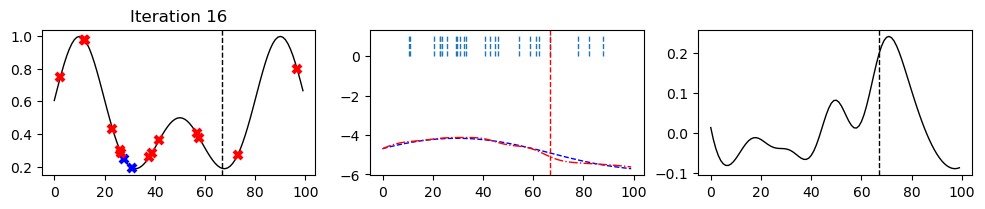

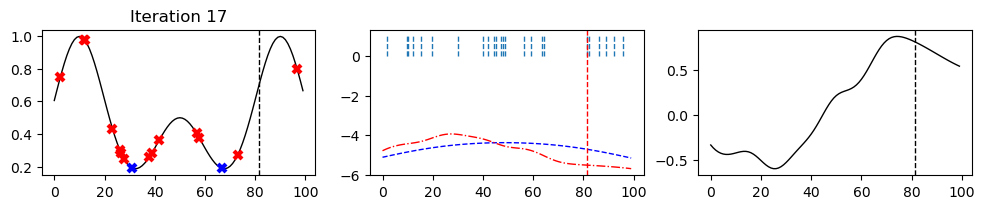

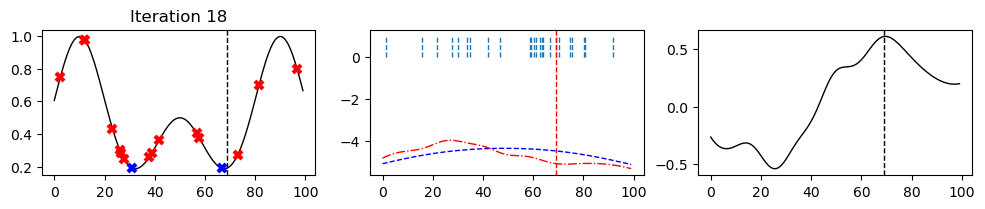

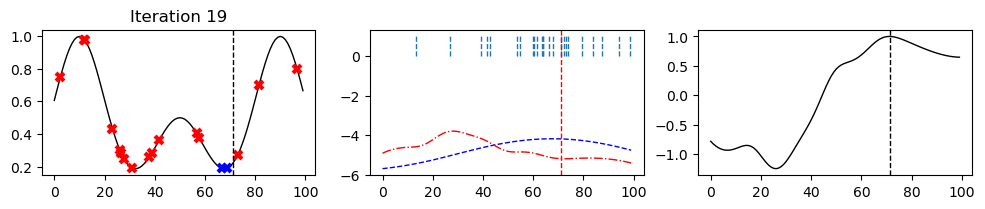

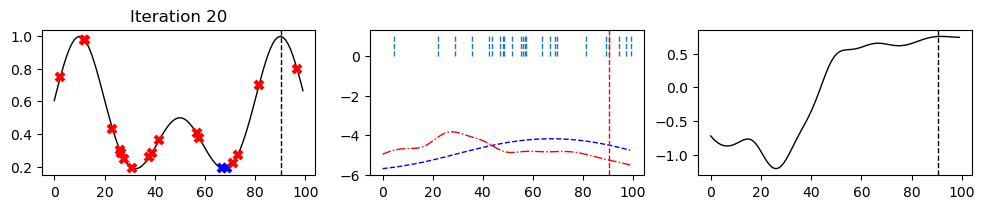

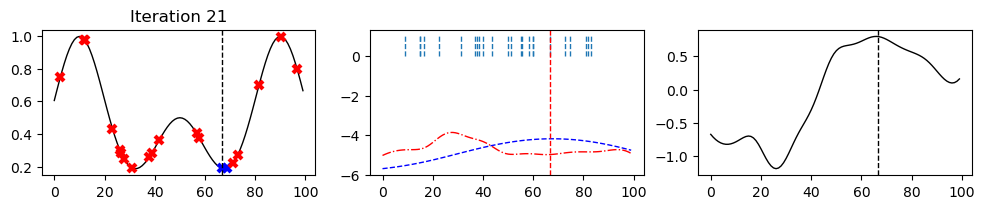

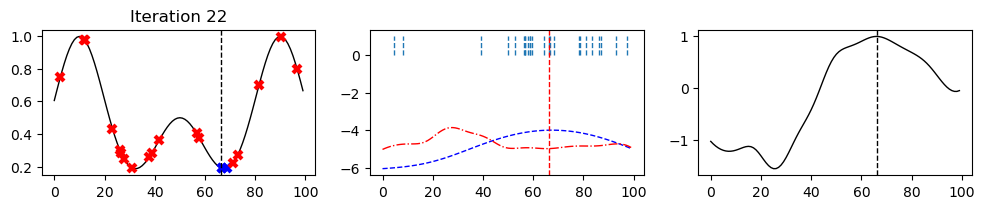

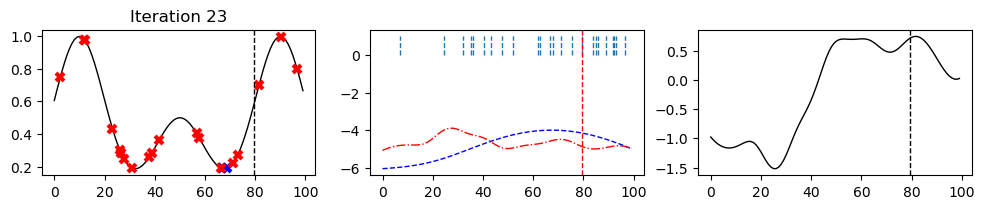

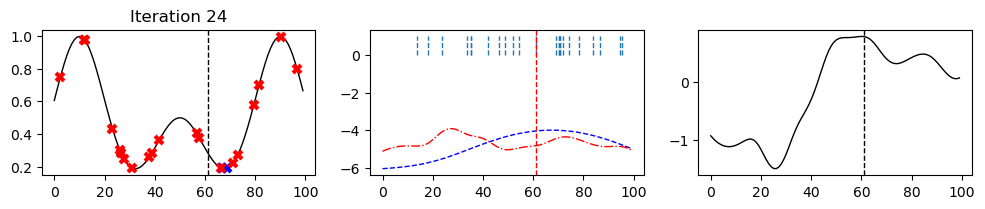

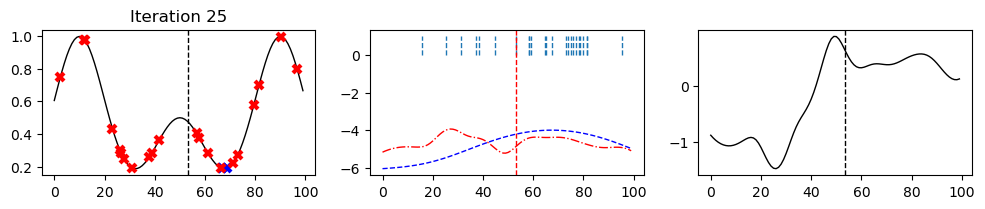

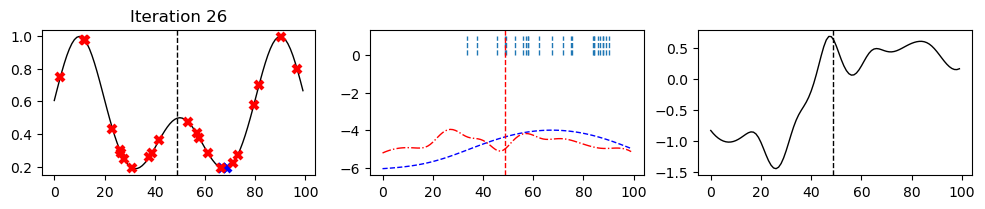

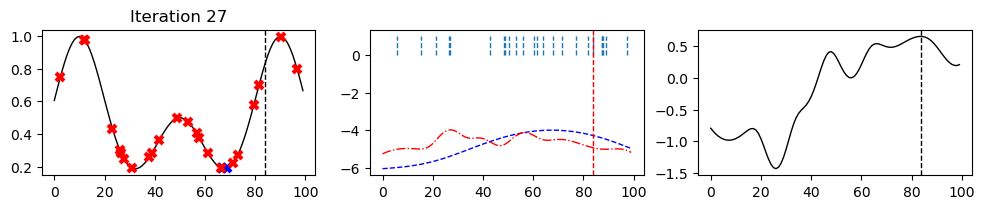

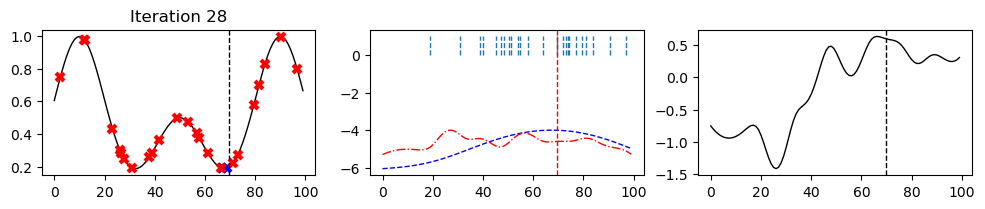

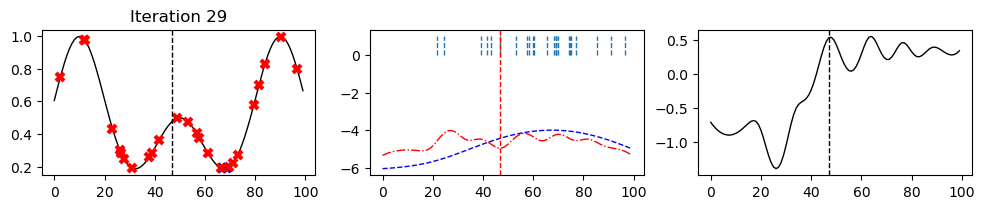

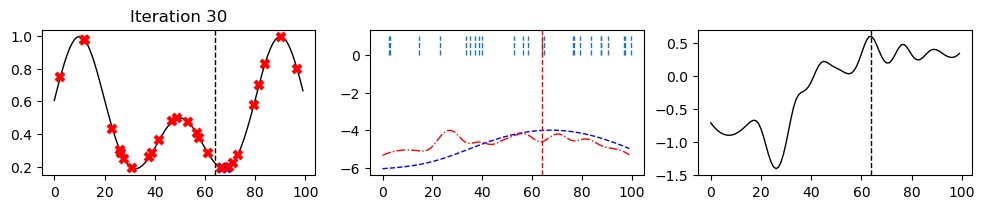

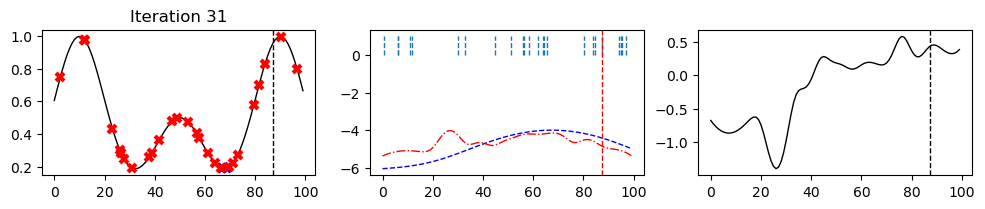

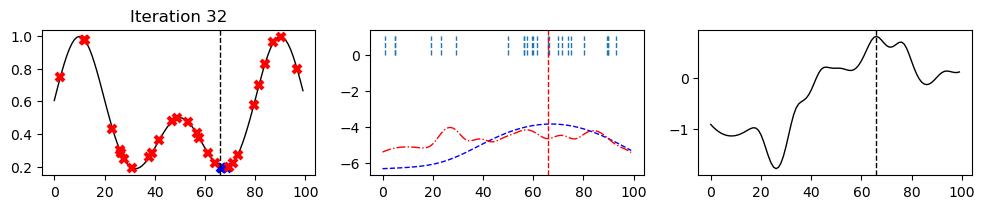

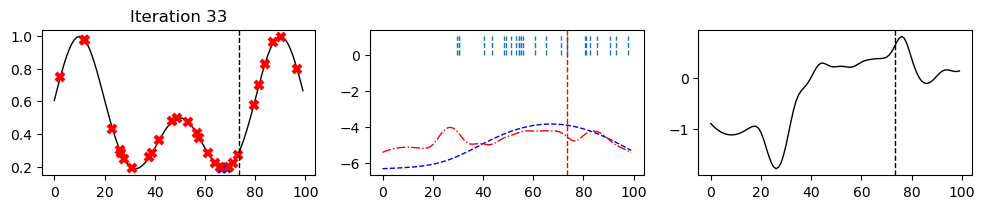

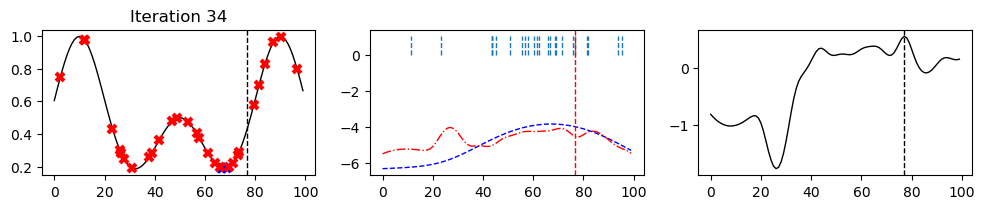

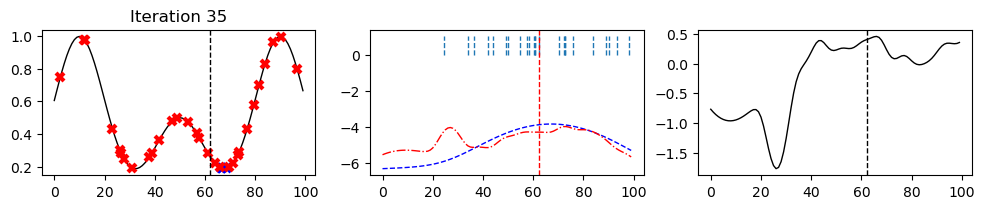

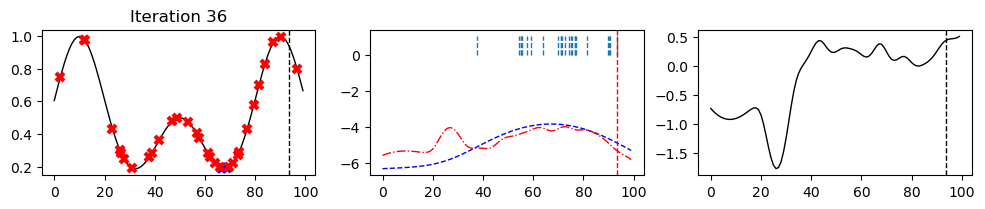

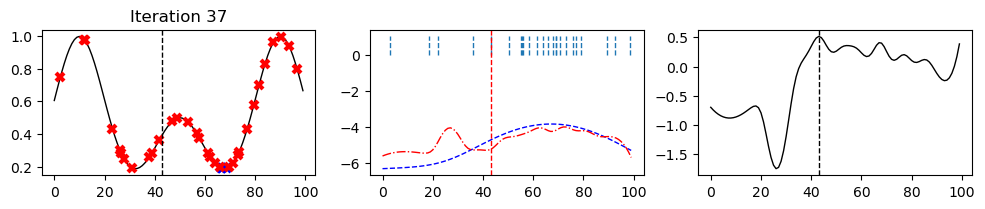

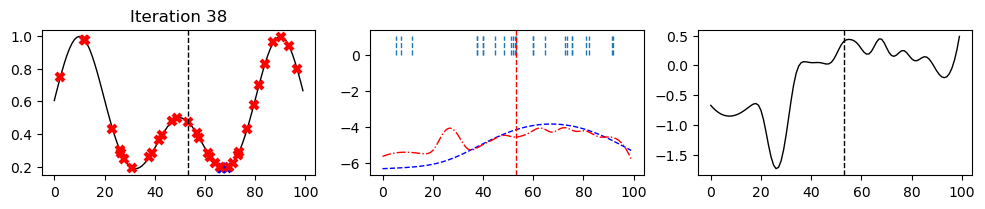

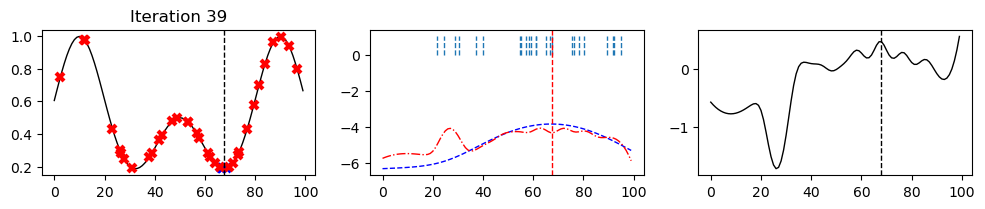

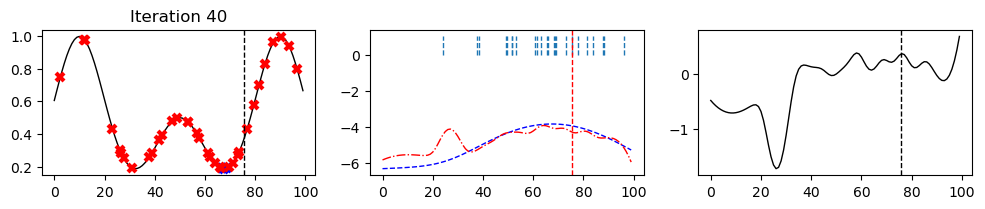

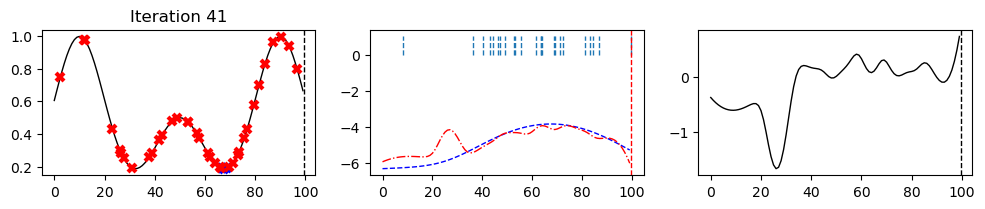

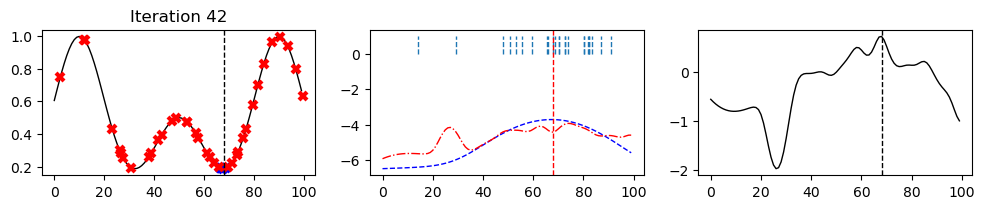

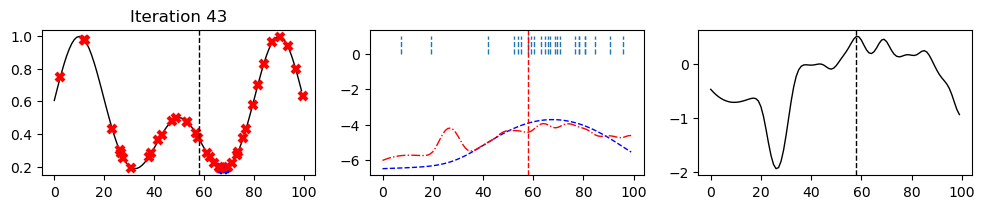

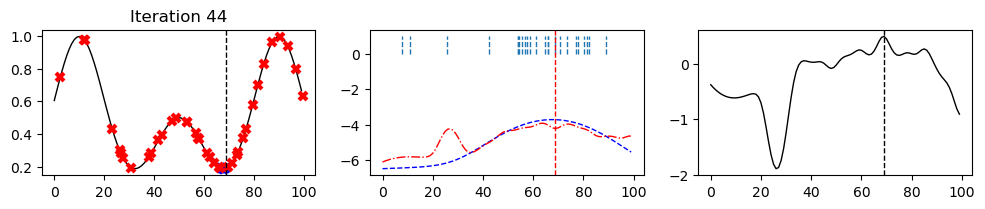

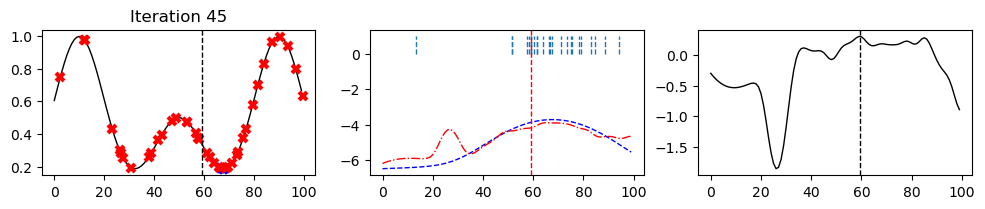

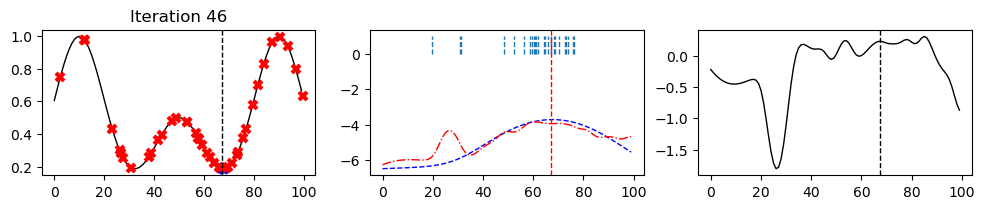

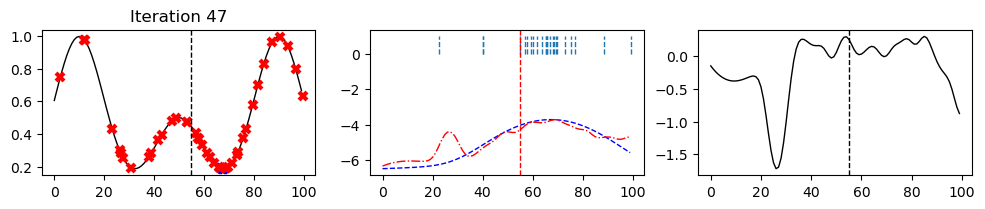

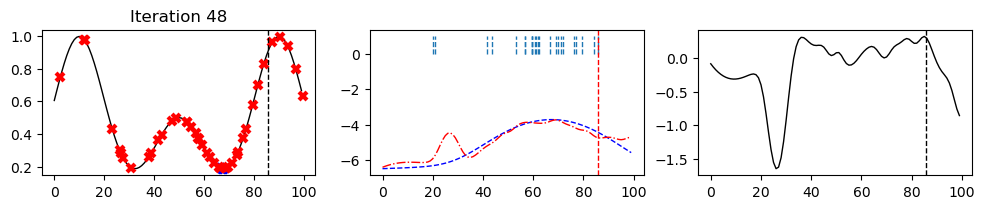

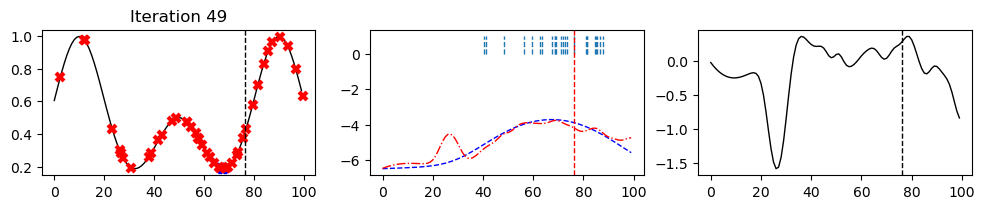

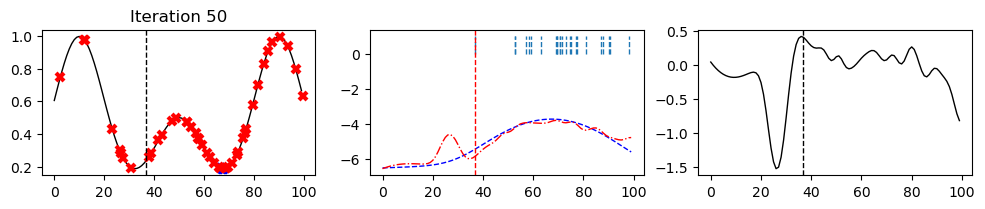

In [34]:
# Initialize samples
values = np.array([],dtype=float)
scores = np.array([],dtype=float)


best_value = np.inf
best_score = np.inf

rng1 = np.random.RandomState(SEED)
rng2 = np.random.RandomState(SEED)

for i in range(N_TRIALS):
    if len(scores) < N_STARTUP_TRIALS:
        next_value = rng1.uniform(LB, UB)
    else:
        n = len(scores)
        indices_below, indices_above = split_observation_pairs(scores, default_gamma(n))
        below_values = build_observation(values, indices_below)
        above_values = build_observation(values, indices_above)

        #lossの小さい点の数から計算する
        below_weights = calculate_weights(len(below_values))
        #lossの小さい点から計算する
        below_mus,below_sigmas = calculate_numerical_params(below_values)

        #lossの小さい点の数から計算する
        above_weights = calculate_weights(len(above_values))
        #lossの小さい点から計算する
        above_mus,above_sigmas = calculate_numerical_params(above_values)

        #lossの小さい点からn_samples分だけサンプルする(candidate)
        samples_below = sample(below_mus,below_sigmas,below_weights,rng2,i)

        #サンプル後に尤度を計算する
        log_likelihoods_below = gmm_log_pdf(samples_below,below_weights,below_mus,below_sigmas)
        log_likelihoods_above = gmm_log_pdf(samples_below,above_weights,above_mus,above_sigmas)

        next_value = compare(samples_below,log_likelihoods_below,log_likelihoods_above)
        

    if len(values) < N_STARTUP_TRIALS:
        plt.figure(figsize=(12, N_TRIALS * 3))
        plt.subplots_adjust(hspace=0.6)

        plt.subplot(N_TRIALS, 3, 3 * i + 1)
        plot_points(X, Y,  values, scores, next_value, show_legend=i==0)
        plt.title(f'Iteration {i+1}')
        
        plt.show()
    else:
        show_legend = len(values)==N_STARTUP_TRIALS
        n_lower = len(below_values)
        plt.figure(figsize=(12, N_TRIALS * 3))
        plt.subplots_adjust(hspace=0.6)
        
        plt.subplot(N_TRIALS, 3, 3 * i + 1)
        plot_approximation(X, Y,values,scores, indices_below,indices_above, next_value, show_legend=show_legend)
        plt.title(f'Iteration {i+1}')

        below = gmm_log_pdf(X,below_weights,below_mus,below_sigmas)
        above = gmm_log_pdf(X,above_weights,above_mus,above_sigmas)
        
        plt.subplot(N_TRIALS, 3, 3 * i + 2)
        plot_density(X,below,above,samples_below,next_value, show_legend=show_legend)

        plt.subplot(N_TRIALS, 3, 3 * i + 3)
        plot_acquisition(X, below-above, next_value, show_legend=show_legend)
        
        plt.show()
        
    # Obtain next noisy sample from the objective function
    next_score = f(next_value)
    
    if best_score > next_score:
        best_score = next_score
        best_value = next_value
    
    # Add sample to previous samples
    values = np.hstack((values, next_value))
    scores = np.hstack((scores, next_score))


In [35]:
values

array([41.70220047, 38.79474386, 12.13573727, 96.7195282 , 57.66183808,
       37.83559039, 73.10166022,  2.41438056, 27.70555063, 11.99091416,
       23.16481905, 30.79452751, 56.6480641 , 26.65213798, 26.1396289 ,
       66.87439802, 81.49004034, 68.92620701, 71.20731731, 90.43460099,
       66.68646664, 66.27349273, 79.44902313, 61.12881026, 53.30993077,
       48.70800099, 83.8219169 , 69.61444087, 46.95310389, 63.81477417,
       87.23653299, 65.98515153, 73.52088251, 76.81522335, 62.19262496,
       93.51257883, 43.01519351, 53.17027625, 67.5870455 , 75.60328348,
       99.58249262, 67.9939606 , 57.89439103, 68.77775884, 59.2677218 ,
       67.24546706, 54.88368195, 85.60933189, 76.23509785, 36.676959  ])

In [36]:
print(best_value)
print(best_score)

67.58704549859212
0.18712776660002622


In [37]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    x = trial.suggest_uniform('x', LB,UB)
    return f(x,NOISE)

study = optuna.create_study(sampler=TPESampler(n_startup_trials=N_STARTUP_TRIALS,seed=SEED))
study.optimize(objective, n_trials=N_TRIALS)

[I 2021-09-28 21:17:26,222] A new study created in memory with name: no-name-3fc15959-a152-4b2d-b71b-bed64edd3969
[I 2021-09-28 21:17:26,224] Trial 0 finished with value: 0.35999446117135947 and parameters: {'x': 41.7022004702574}. Best is trial 0 with value: 0.35999446117135947.
[I 2021-09-28 21:17:26,227] Trial 1 finished with value: 0.2819723729195692 and parameters: {'x': 38.794743864733654}. Best is trial 1 with value: 0.2819723729195692.
[I 2021-09-28 21:17:26,231] Trial 2 finished with value: 0.9752507843155712 and parameters: {'x': 12.135737274356906}. Best is trial 1 with value: 0.2819723729195692.
[I 2021-09-28 21:17:26,234] Trial 3 finished with value: 0.7958085106927661 and parameters: {'x': 96.71952819542315}. Best is trial 1 with value: 0.2819723729195692.
[I 2021-09-28 21:17:26,237] Trial 4 finished with value: 0.37718926583327445 and parameters: {'x': 57.661838077268264}. Best is trial 1 with value: 0.2819723729195692.
[I 2021-09-28 21:17:26,241] Trial 5 finished with v

In [38]:
print(study.best_params)
print(study.best_value)

{'x': 67.58704549859212}
0.18712776660002622
